# Ibis demo

The purpose of this notebook is to show how easy analytics in Python can be.

## Setup

TODO: this section

In short, `gh repo clone ibis-project/ibis && cd ibis && pip install -e .`.

Pip install other packages used below.

## Get data platform info

Reuse the dbt profile. dbt should make this + the below connection easy.

In [1]:
import yaml

# replace as needed
PROFILE_PATH = "/root/.dbt/profiles.yml"
PROFILE_NAME = "snowflake"
PROFILE_OUTPUT = "dev"

# read in dbt profile
with open(PROFILE_PATH, "r") as f:
    profiles = yaml.safe_load(f)
    profile = profiles[PROFILE_NAME]["outputs"][PROFILE_OUTPUT]

# build connection parameters from profile
conn_params = {
    "account": profile["account"],
    "user": profile["user"],
    "role": profile["role"],
    "warehouse": profile["warehouse"],
    "database": profile["database"],
    "schema": profile["schema"],
    "authenticator": profile["authenticator"],
}

## Start with Ibis

Import.

In [2]:
import ibis

## Create a client object

dbt should make this easier.

It took me longer than I'd like to admit to figure out the specifics of the string needed.

In [3]:
s = ibis.connect(
    f"snowflake://{conn_params['user']}:_@{conn_params['account']}/{conn_params['database']}/{conn_params['schema']}?warehouse={conn_params['warehouse']}&role={conn_params['role']}&authenticator={conn_params['authenticator']}",
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


check for available tables

In [4]:
[x for x in s.list_tables() if "orders" in x]

['int_orders', 'orders', 'stg_orders']

there's a method for that

In [5]:
s.list_tables(like=".*orders.*")

['int_orders', 'orders', 'stg_orders']

In [6]:
s.list_tables(like=".*_py.*")

['cluster_py',
 'describe_py',
 'forecast_py',
 'forecast_score_py',
 'forecast_train_py',
 'fuzz_py',
 'pivot_py',
 'stg_test_py',
 'test_py',
 'unfuzz_py',
 'unfuzzed_py']

In [7]:
s.list_tables(like="stg_.*")

['stg_customers',
 'stg_locations',
 'stg_order_items',
 'stg_orders',
 'stg_products',
 'stg_supplies',
 'stg_test_py']

## Analytics

Let's rewrite some SQL in Python for demonstration purposes -- my favorite! (this is becoming my life, please help me)

In [8]:
stg_orders = s.table("stg_orders")
stg_orders = stg_orders.relabel({col: str(col).lower() for col in stg_orders.columns})
stg_orders.limit(5).execute()

,order_id,location_id,customer_id,order_total,tax_paid,ordered_at
0,d3d0ff03-c478-4495-bda0-5e86a97095d1,fb199829-e587-4d3e-8de0-efc0156c0d48,90bfe313-2191-4c5e-b87f-ae95261f9d73,18.06,1.06,2019-11-29 17:53:00
1,b3431f2e-5ac0-4b79-91e5-448e50230f7e,fb199829-e587-4d3e-8de0-efc0156c0d48,0da08ba9-a93b-41b9-8069-0220a3565810,4.25,0.25,2019-11-29 08:38:00
2,3baf2e72-547a-47d2-8a17-6e475f4dc369,fb199829-e587-4d3e-8de0-efc0156c0d48,fb5057be-92d7-4962-8b92-62f569211fe8,5.31,0.31,2019-11-29 08:14:00
3,537d04a3-6250-416a-a728-f963eff0bf69,fb199829-e587-4d3e-8de0-efc0156c0d48,7dca001f-ea65-4cec-bb0e-eca950aa8832,5.31,0.31,2019-11-29 07:43:00
4,e42569bc-588a-4b87-b6db-dbcb1d7acf8c,fb199829-e587-4d3e-8de0-efc0156c0d48,1a88f733-b6f6-46a1-9328-9594ac879645,5.31,0.31,2019-11-29 09:57:00


In [9]:
stg_order_items = s.table("stg_order_items")
stg_order_items = stg_order_items.relabel(
    {col: str(col).lower() for col in stg_order_items.columns}
)
stg_order_items.limit(5).execute()

,order_item_id,order_id,product_id
0,86d958ee-7533-4fcd-b08a-60079920de42,cf6fb65b-beb0-4236-9d2a-79d40dab0506,JAF-002
1,94e72042-ef2b-40de-91a7-0d5a278662da,58ac7bd3-a41f-4783-8019-e34c5948f714,BEV-005
2,fb088dee-1653-497b-8e81-3e2516c7b272,62c19dd2-2d77-4dc5-9e1e-1339fcfedd0d,BEV-004
3,14cccd44-b016-4cbb-acf3-91f59b6cda35,1cdb4d79-a396-44e7-aeba-f1cb96483d14,BEV-004
4,6f62448c-bda0-4f9b-8529-6d43fedf42a4,3b1f8463-0cff-42a5-ac19-77bf3f3b60a4,BEV-003


In [10]:
stg_products = s.table("stg_products")
stg_products = stg_products.relabel(
    {col: str(col).lower() for col in stg_products.columns}
)
stg_products.execute()

,product_id,product_name,product_type,product_description,product_price,is_food_item,is_drink_item
0,JAF-001,nutellaphone who dis?,jaffle,nutella and banana jaffle,11.0,1,0
1,JAF-002,doctor stew,jaffle,house-made beef stew jaffle,11.0,1,0
2,JAF-003,the krautback,jaffle,lamb and pork bratwurst with house-pickled cab...,12.0,1,0
3,JAF-004,flame impala,jaffle,pulled pork and pineapple al pastor marinated ...,14.0,1,0
4,JAF-005,mel-bun,jaffle,"melon and minced beef bao, in a jaffle, savory...",12.0,1,0
5,BEV-001,tangaroo,beverage,mango and tangerine smoothie,6.0,0,1
6,BEV-002,chai and mighty,beverage,oatmilk chai latte with protein boost,5.0,0,1
7,BEV-003,vanilla ice,beverage,iced coffee with house-made french vanilla syrup,6.0,0,1
8,BEV-004,for richer or pourover,beverage,daily selection of single estate beans for a d...,7.0,0,1
9,BEV-005,adele-ade,beverage,"a kiwi and lime agua fresca, hello from the ot...",4.0,0,1


In [11]:
stg_locations = s.table("stg_locations")
stg_locations = stg_locations.relabel(
    {col: str(col).lower() for col in stg_locations.columns}
)
stg_locations.execute()

,location_id,location_name,tax_rate,opened_at
0,2018dba7-0d00-46e1-9e49-9a99db25649b,Philadelphia,0.0600,2016-09-01
1,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,Brooklyn,0.0400,2017-03-12
2,fb199829-e587-4d3e-8de0-efc0156c0d48,Chicago,0.0625,2018-04-29
3,eed97b42-081b-4ed8-b5e4-32a45659094d,San Francisco,0.0750,2018-05-09
4,b8d4c6a3-41cd-42aa-857f-3183be9dca08,New Orleans,0.0400,2019-03-10


In [12]:
stg_supplies = s.table("stg_supplies")
stg_supplies = stg_supplies.relabel(
    {col: str(col).lower() for col in stg_supplies.columns}
)
stg_supplies.limit(5).execute()

,supply_uuid,supply_id,product_id,supply_name,supply_cost,is_perishable_supply
0,0c1009250b32f19a8c96b44ba55d3cb3,SUP-001,JAF-001,compostable cutlery - knife,0.07,None
1,df0b5eb60008c8458493b56369126201,SUP-002,JAF-001,cutlery - fork,0.07,None
2,1a9db79a0dffc7f7d9a4d44306cddbd3,SUP-003,JAF-001,serving boat,0.11,None
3,a9ff71f9b28f5ff09ec765c563ebe547,SUP-004,JAF-001,napkin,0.04,None
4,de2daf744eb5b1586ce87485e5d0dc94,SUP-009,JAF-001,bread,0.33,None


In [13]:
print(ibis.snowflake.compile(stg_supplies))

SELECT t0."SUPPLY_UUID" AS supply_uuid, t0."SUPPLY_ID" AS supply_id, t0."PRODUCT_ID" AS product_id, t0."SUPPLY_NAME" AS supply_name, t0."SUPPLY_COST" AS supply_cost, t0."IS_PERISHABLE_SUPPLY" AS is_perishable_supply 
FROM stg_supplies AS t0


In [14]:
count_food_items = stg_products.is_food_item.sum()
# print(ibis.snowflake.compile(count_food_items))
count_food_items.execute()

5

In [15]:
count_drink_items = stg_products.is_drink_item.sum()
count_drink_items.execute()

5

In [16]:
count_items = stg_products.product_id.count()
count_items.execute()

10

In [17]:
subtotal_drink_items = stg_products.product_price.sum(
    where=stg_products.is_drink_item == 1
)
subtotal_drink_items.execute()

28.0

In [18]:
subtotal_food_items = stg_products.product_price.sum(
    where=stg_products.is_food_item == 1
)
subtotal_food_items.execute()

60.0

In [19]:
subtotal = stg_products.product_price.sum()
subtotal.execute()

88.0

In [20]:
order_items_summary = (
    stg_order_items.left_join(stg_products, "product_id")
    .group_by("order_id")
    .aggregate(
        count_food_items=count_food_items,
        count_drink_items=count_drink_items,
        count_items=count_items,
        subtotal_drink_items=subtotal_drink_items,
        subtotal_food_items=subtotal_food_items,
        subtotal=subtotal,
    )
)

order_items_summary.limit(5).execute()

,order_id,count_food_items,count_drink_items,count_items,subtotal_drink_items,subtotal_food_items,subtotal
0,cf6fb65b-beb0-4236-9d2a-79d40dab0506,1,1,2,6.0,11.0,17.0
1,62c19dd2-2d77-4dc5-9e1e-1339fcfedd0d,0,1,1,7.0,NaN,7.0
2,3b1f8463-0cff-42a5-ac19-77bf3f3b60a4,0,1,1,6.0,NaN,6.0
3,e17bca93-f5f6-462d-b760-d9ee5aef80df,0,2,2,13.0,NaN,13.0
4,6da27f28-17f0-47a3-b3ea-062930fdcad3,0,1,1,6.0,NaN,6.0


In [21]:
# TODO: not implemented apparently
# order_items_summary = order_items_summary.fillna(0)
# order_items_summary.limit(5).execute()

In [22]:
order_supplies_summary = (
    stg_order_items.left_join(stg_supplies, "product_id")
    .group_by("order_id")
    .aggregate(order_cost=stg_supplies.supply_cost.sum())
)
order_supplies_summary.limit(5).execute()

,order_id,order_cost
0,64fcec1b-6869-4ca6-a1e4-1cc5281c7748,1.75
1,f17b1e01-8924-4bb3-84a8-383cb1ac0265,4.32
2,8842fd10-a099-46d6-a4e6-f2dacb0cfd7a,1.54
3,f4a4516d-b042-45db-975f-3b0278b032cf,12.59
4,c7848404-ae05-4ffc-a97b-403024a12ed2,5.26


In [23]:
joined = (
    stg_orders.left_join(order_items_summary, "order_id")
    .relabel({"order_id_x": "order_id"})
    .drop("order_id_y")
    .left_join(order_supplies_summary, "order_id")
    .relabel({"order_id_x": "order_id"})
    .drop("order_id_y")
    .left_join(stg_locations, "location_id")
    .relabel({"location_id_x": "location_id"})
    .drop("location_id_y")
)

joined = joined.mutate(
    customer_order_index=ibis.row_number().over(
        ibis.window(group_by=stg_orders.customer_id, order_by=stg_orders.ordered_at)
    )
    + 1
)

joined.limit(5).execute()

,order_id,location_id,customer_id,order_total,tax_paid,ordered_at,count_food_items,count_drink_items,count_items,subtotal_drink_items,subtotal_food_items,subtotal,order_cost,location_name,tax_rate,opened_at,customer_order_index
0,7e595a22-883c-4f03-bb59-806747a3d52b,fb199829-e587-4d3e-8de0-efc0156c0d48,e589dbbf-2f29-4755-9ff4-7f02bfbec614,93.50,5.50,2018-06-24 12:56:00,5,5,10,31.0,57.0,88.0,13.62,Chicago,0.0625,2018-04-29,1
1,e88bda71-eaf3-421a-980f-213010589d2f,fb199829-e587-4d3e-8de0-efc0156c0d48,e589dbbf-2f29-4755-9ff4-7f02bfbec614,91.37,5.37,2018-07-07 13:36:00,5,5,10,28.0,58.0,86.0,17.78,Chicago,0.0625,2018-04-29,2
2,76436b13-78c9-495f-b045-42e35a68a844,fb199829-e587-4d3e-8de0-efc0156c0d48,e589dbbf-2f29-4755-9ff4-7f02bfbec614,93.50,5.50,2018-07-21 11:38:00,5,5,10,25.0,63.0,88.0,21.48,Chicago,0.0625,2018-04-29,3
3,63ca7451-93ac-47ae-80cb-af893c40af19,fb199829-e587-4d3e-8de0-efc0156c0d48,e589dbbf-2f29-4755-9ff4-7f02bfbec614,95.62,5.62,2018-07-28 13:00:00,5,5,10,26.0,64.0,90.0,21.07,Chicago,0.0625,2018-04-29,4
4,9623f0ae-8b75-4fe7-a1b7-c14c7831b624,fb199829-e587-4d3e-8de0-efc0156c0d48,e589dbbf-2f29-4755-9ff4-7f02bfbec614,94.56,5.56,2018-07-29 10:46:00,5,5,10,28.0,61.0,89.0,21.42,Chicago,0.0625,2018-04-29,5


In [24]:
t = (
    joined.customer_order_index.value_counts()
    .order_by("customer_order_index")
    .execute()
)
t

,customer_order_index,count
0,1,2702
1,2,2702
2,3,2702
3,4,2701
4,5,2700
...,...,...
1563,1564,1
1564,1565,1
1565,1566,1
1566,1567,1


In [25]:
final = joined.mutate(
    first_order=(joined.customer_order_index == 1).ifelse(1, 0),
    is_food_order=(joined.count_food_items > 0).ifelse(1, 0),
    is_drink_order=(joined.count_drink_items > 0).ifelse(1, 0),
)
final.limit(5).execute()

,order_id,location_id,customer_id,order_total,tax_paid,ordered_at,count_food_items,count_drink_items,count_items,subtotal_drink_items,subtotal_food_items,subtotal,order_cost,location_name,tax_rate,opened_at,customer_order_index,first_order,is_drink_order,is_food_order
0,8a5ebc69-772b-4cf4-bb1c-433e6cdea789,2018dba7-0d00-46e1-9e49-9a99db25649b,6e44ddbb-ea6f-4f55-850b-400371216cfc,7.42,0.42,2017-03-01 16:08:00,0,1,1,7.0,NaN,7.0,0.82,Philadelphia,0.06,2016-09-01,1,1,1,0
1,f3e980cd-0fbf-40a7-be01-bbbc3c8ab95e,2018dba7-0d00-46e1-9e49-9a99db25649b,6e44ddbb-ea6f-4f55-850b-400371216cfc,6.36,0.36,2017-03-03 12:27:00,0,1,1,6.0,NaN,6.0,0.82,Philadelphia,0.06,2016-09-01,2,0,1,0
2,67367285-5be7-4f63-8657-a5f68f703482,2018dba7-0d00-46e1-9e49-9a99db25649b,6e44ddbb-ea6f-4f55-850b-400371216cfc,19.07,1.08,2017-03-10 14:45:00,1,1,2,6.0,12.0,18.0,3.93,Philadelphia,0.06,2016-09-01,3,0,1,1
3,dc2b813f-8849-4e2e-9ed3-6a8d0932214c,2018dba7-0d00-46e1-9e49-9a99db25649b,6e44ddbb-ea6f-4f55-850b-400371216cfc,16.96,0.96,2017-03-14 14:47:00,1,1,2,5.0,11.0,16.0,2.96,Philadelphia,0.06,2016-09-01,4,0,1,1
4,0d5b21ca-6193-4d08-9bcd-6cb75a5c5fc9,2018dba7-0d00-46e1-9e49-9a99db25649b,6e44ddbb-ea6f-4f55-850b-400371216cfc,19.07,1.08,2017-03-15 14:53:00,1,1,2,6.0,12.0,18.0,5.20,Philadelphia,0.06,2016-09-01,5,0,1,1


In [26]:
orders = final

In [27]:
stg_customers = s.table("stg_customers")
stg_customers = stg_customers.relabel(
    {col: str(col).lower() for col in stg_customers.columns}
)
stg_customers.limit(5).execute()

,customer_id,customer_name
0,15df7af1-ef13-473f-bbea-deedde94ac32,Samuel Stout
1,face746f-5b3a-4299-b3ea-a83c6a3a6712,James Gutierrez
2,e4a57063-7fff-4e07-acec-6c255e491a9b,Judy Alvarez
3,6338ad00-dbf7-419a-9882-be4926d0deff,Vanessa Howell
4,6d28d61c-33c4-4759-85ab-80dcd23e17ec,Alyssa Riddle


In [28]:
count_orders = orders.order_id.count()
count_orders.execute()

1884244

In [29]:
order_summary = orders.group_by("customer_id").aggregate(
    count_lifetime_orders=count_orders,
    is_repeat_buyer=(count_orders > 1).ifelse(True, False),
    first_ordered_at=orders.ordered_at.min(),
    last_ordered_at=orders.ordered_at.max(),
    lifetime_spend_pre_tax=orders.subtotal.sum(),
    lifetime_spend=orders.order_total.sum(),
)
order_summary.limit(5).execute()

,customer_id,count_lifetime_orders,is_repeat_buyer,first_ordered_at,last_ordered_at,lifetime_spend_pre_tax,lifetime_spend
0,19afca10-b142-4104-96ab-55344d293007,1081,True,2018-08-27 07:56:00,2022-10-13 07:03:00,6088.0,6464.09
1,191bcfaa-f1f3-4e9e-a12e-75fe4e0e7f6c,999,True,2018-10-10 08:04:00,2022-10-13 07:55:00,5585.0,5930.09
2,c7c47ee5-8f45-41ca-8f5b-571485a4fa66,525,True,2018-10-21 13:03:00,2022-10-11 12:46:00,11230.0,11930.10
3,8046f434-4927-4e70-a76d-7e6138e160a0,648,True,2018-10-22 13:06:00,2022-10-13 15:08:00,7643.0,8118.14
4,0f3bb7fc-a5f8-4278-a20e-395a42669d5e,1020,True,2018-11-19 08:25:00,2022-10-13 08:05:00,5722.0,6075.52


In [30]:
joined = (
    stg_customers.left_join(order_summary, "customer_id")
    .relabel({"customer_id_x": "customer_id"})
    .drop("customer_id_y")
)
joined = joined.mutate(customer_type=joined.is_repeat_buyer.ifelse("returning", "new"))

joined.limit(5).execute()

,customer_id,customer_name,count_lifetime_orders,is_repeat_buyer,first_ordered_at,last_ordered_at,lifetime_spend_pre_tax,lifetime_spend,customer_type
0,15df7af1-ef13-473f-bbea-deedde94ac32,Samuel Stout,1549,True,2016-09-01 07:08:00,2022-10-13 07:12:00,8663.0,9182.78,returning
1,face746f-5b3a-4299-b3ea-a83c6a3a6712,James Gutierrez,1555,True,2016-09-01 07:50:00,2022-10-13 08:10:00,8708.0,9230.48,returning
2,e4a57063-7fff-4e07-acec-6c255e491a9b,Judy Alvarez,1524,True,2016-09-01 07:57:00,2022-10-13 07:41:00,8566.0,9079.96,returning
3,6338ad00-dbf7-419a-9882-be4926d0deff,Vanessa Howell,1071,True,2016-09-01 11:15:00,2022-10-13 15:15:00,11804.0,12511.34,returning
4,6d28d61c-33c4-4759-85ab-80dcd23e17ec,Alyssa Riddle,484,True,2016-09-01 16:16:00,2022-10-11 15:11:00,5035.0,5336.76,returning


In [31]:
customers = joined

## Visualize

In [32]:
import seaborn as sns

import matplotlib.pyplot as plt

# setup viz defaults
sns.set_theme()
sns.set(rc={"figure.figsize": (10, 8)})
sns.set_style("darkgrid")
plt.style.use(["dark_background"])

In [33]:
df = customers.execute()

In [34]:
df

,customer_id,customer_name,count_lifetime_orders,is_repeat_buyer,first_ordered_at,last_ordered_at,lifetime_spend_pre_tax,lifetime_spend,customer_type
0,15df7af1-ef13-473f-bbea-deedde94ac32,Samuel Stout,1549,True,2016-09-01 07:08:00,2022-10-13 07:12:00,8663.0,9182.78,returning
1,face746f-5b3a-4299-b3ea-a83c6a3a6712,James Gutierrez,1555,True,2016-09-01 07:50:00,2022-10-13 08:10:00,8708.0,9230.48,returning
2,e4a57063-7fff-4e07-acec-6c255e491a9b,Judy Alvarez,1524,True,2016-09-01 07:57:00,2022-10-13 07:41:00,8566.0,9079.96,returning
3,6338ad00-dbf7-419a-9882-be4926d0deff,Vanessa Howell,1071,True,2016-09-01 11:15:00,2022-10-13 15:15:00,11804.0,12511.34,returning
4,6d28d61c-33c4-4759-85ab-80dcd23e17ec,Alyssa Riddle,484,True,2016-09-01 16:16:00,2022-10-11 15:11:00,5035.0,5336.76,returning
...,...,...,...,...,...,...,...,...,...
2697,02470ed8-6a1a-4b9a-a1d4-5d7ec06cbe02,Kristen King,695,True,2020-02-26 08:04:00,2022-10-13 07:53:00,3928.0,4085.12,returning
2698,1ed58ff6-eddd-455b-97cd-340560a06e53,Theresa Robinson,654,True,2020-02-29 09:09:00,2022-10-13 08:09:00,3656.0,3802.24,returning
2699,878ccd73-1581-41af-8653-a7d3e2b7265e,Ann Ingram,565,True,2020-03-02 09:47:00,2022-10-12 16:01:00,6350.0,6604.00,returning
2700,6e7fc1e6-bf12-41ab-b388-cf4c429d65ee,Patricia Nunez,327,True,2020-03-08 10:52:00,2022-10-13 09:55:00,7167.0,7453.63,returning


<AxesSubplot: xlabel='lifetime_spend', ylabel='Density'>

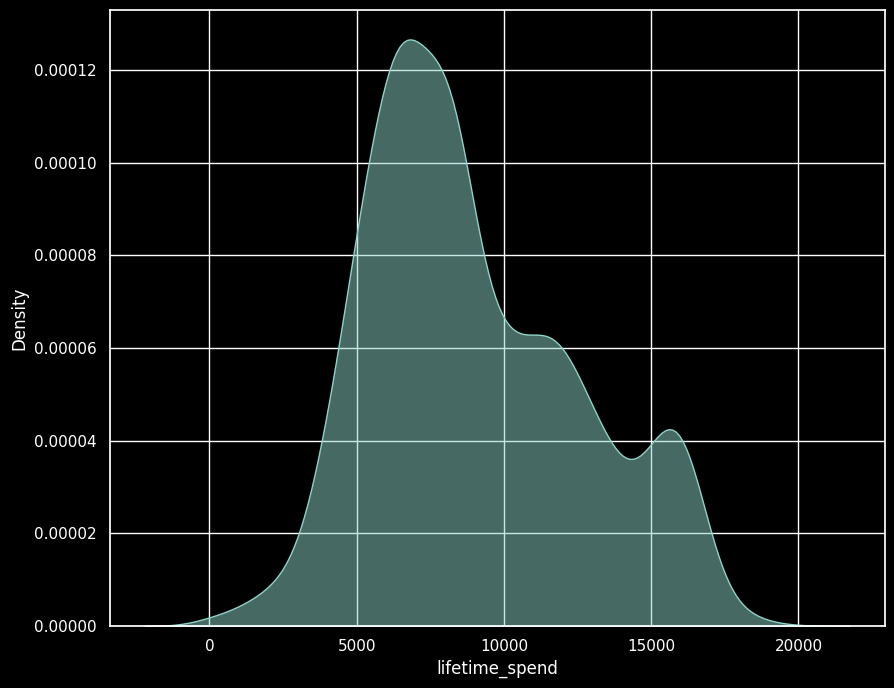

In [35]:
sns.kdeplot(data=df, x="lifetime_spend", fill=True, alpha=0.5)

<AxesSubplot: xlabel='lifetime_spend', ylabel='count_lifetime_orders'>

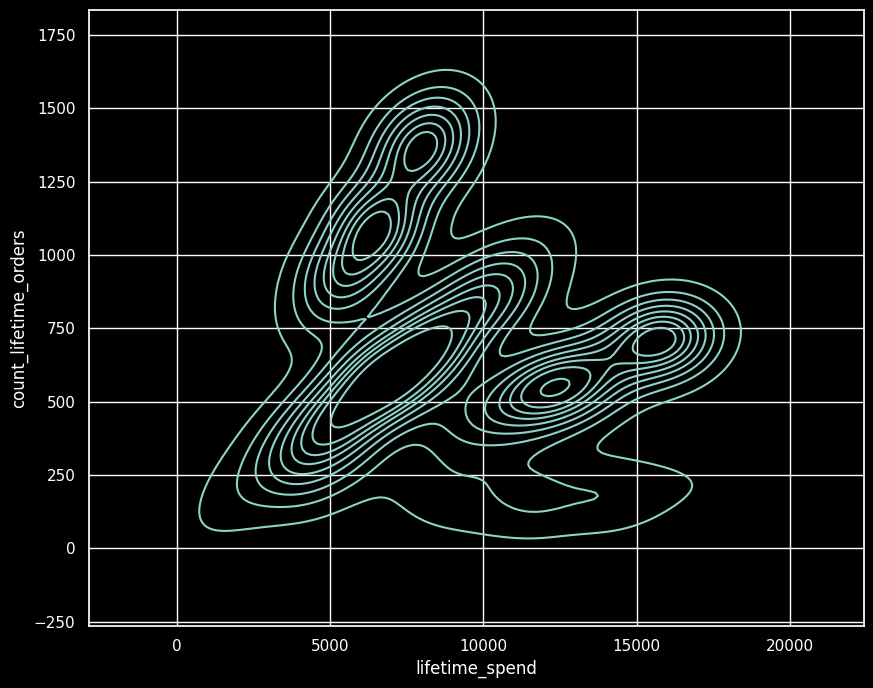

In [36]:
sns.kdeplot(data=df, x="lifetime_spend", y="count_lifetime_orders")

<AxesSubplot: xlabel='lifetime_spend', ylabel='count_lifetime_orders'>

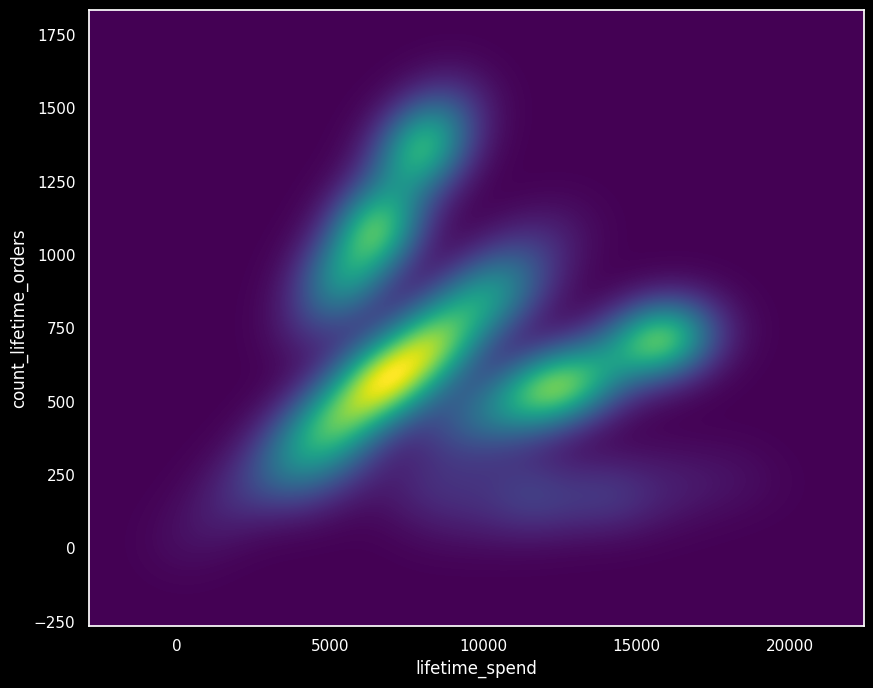

In [37]:
sns.kdeplot(
    data=df,
    x="lifetime_spend",
    y="count_lifetime_orders",
    fill=True,
    thresh=0,
    levels=1000,
    cmap="viridis",
)